# Курс «Машинное обучение в бизнесе»

## Урок 5. Кейс 1. Аномалии и артефакты

### Домашнее задание к уроку 5

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
import os

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.cluster import KMeans, DBSCAN

import warnings

In [2]:
def show_plot_data(data, field_name, title, xlabel):
    plt.figure(figsize =(20,6))
    plt.plot(data.index, data[field_name], 'b')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

In [3]:
def show_difference(data, delta, field_name, label, title, xlabel):
    result = (data[field_name].values[delta:]- data[field_name].values[:-delta])/np.absolute(2 * delta)
    # Потому что производная.
    s = np.std(result)**0.5*3
    plt.figure(figsize=(20,6))
    plt.plot(data.iloc[:-delta].index,result,'.', label=label)
    plt.plot(data.iloc[[delta,-delta]].index,[s, s],'--k',label ='3 sig')
    plt.plot(data.iloc[[delta,-delta]].index,[-s, -s],'--k')
    plt.xlabel(xlabel)
    plt.legend()
    plt.title(title)
    plt.show()
    return result

In [4]:
def split_data_b(data, split_date, index_name):
    return data.loc[data.index.get_level_values(index_name) <= split_date].copy(), \
           data.loc[data.index.get_level_values(index_name) >  split_date].copy()

In [5]:
def show_train_test_data(train, test, data, field_name, xlabel, ylabel, train_label, test_label, title):
    plt.figure( figsize=( 15, 7 ))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(train.index.get_level_values(field_name),train[data.columns[0]], label=train_label)
    plt.plot(test.index.get_level_values(field_name),test[data.columns[0]], label=test_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def show_train_test_data_h(test_b, X_test_pred_gb, y_test_b, data, filed, date, xlabel, ylabel, test_pred_label, test_label, data_label):
    plt.figure(figsize=( 20, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(test_b.index[h:],X_test_pred_gb, label=test_pred_label)
    plt.plot(test_b.index[h:],y_test_b, label=test_label)
    plt.plot(data.loc[date:].index, data.loc[date:][filed], label=data_label)
    plt.legend()
    plt.show()
    er_g = mean_absolute_percentage_error(y_true=y_test_usd_b, y_pred=X_test_usd_pred_gb)
    print('ошибка градиентного бустинга :  ', er_g, '%')

#### Задание 1

Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями.

In [8]:
data = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])

In [9]:
data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [10]:
data.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


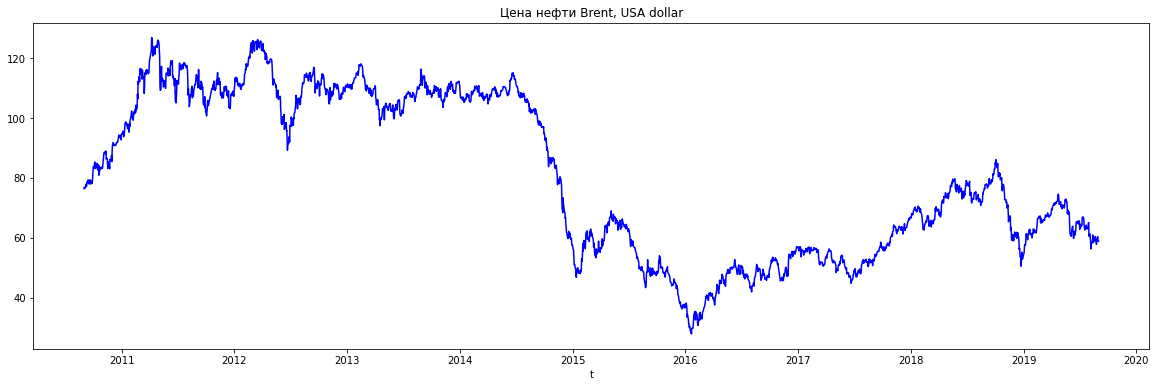

In [11]:
show_plot_data(data, 'Значение', 'Цена нефти Brent, USA dollar', 't')

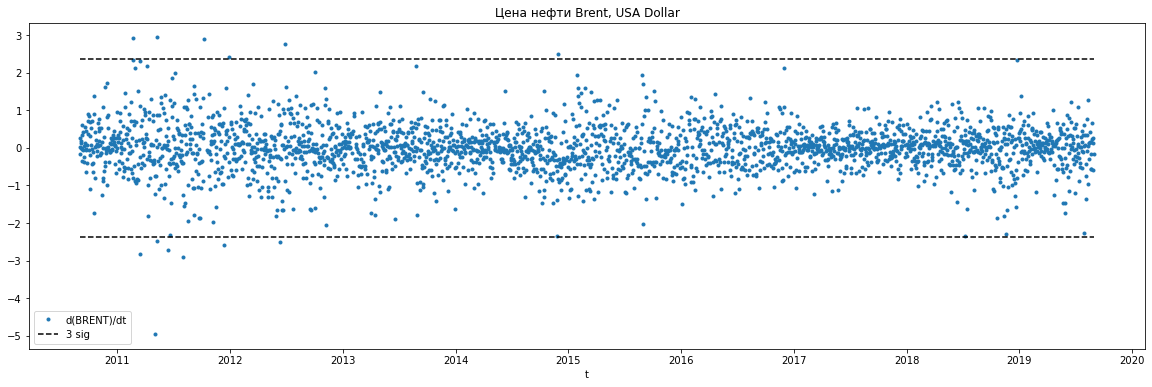

In [12]:
d_data = show_difference(data, 1, 'Значение', 'd(BRENT)/dt', 'Цена нефти Brent, USA Dollar', 't')

#### Задание 2

Добавьте первые разности по стоимости доллара и евро к рублю (можно добавить и сами курсы валют - прошлые значения).

In [13]:
data_usd = pd.read_csv('USD_RUB.csv', index_col=[0], parse_dates=[0])

In [14]:
data_usd.head()

,value
date,
1998-01-01,5.960
1998-01-06,5.963
1998-01-07,5.969
1998-01-09,5.972
1998-01-10,5.974


In [15]:
data_usd.describe()

,value
count,5594.000000
mean,36.885963
std,16.203120
min,5.960000
25%,27.920000
50%,30.375400
75%,45.937150
max,83.591300


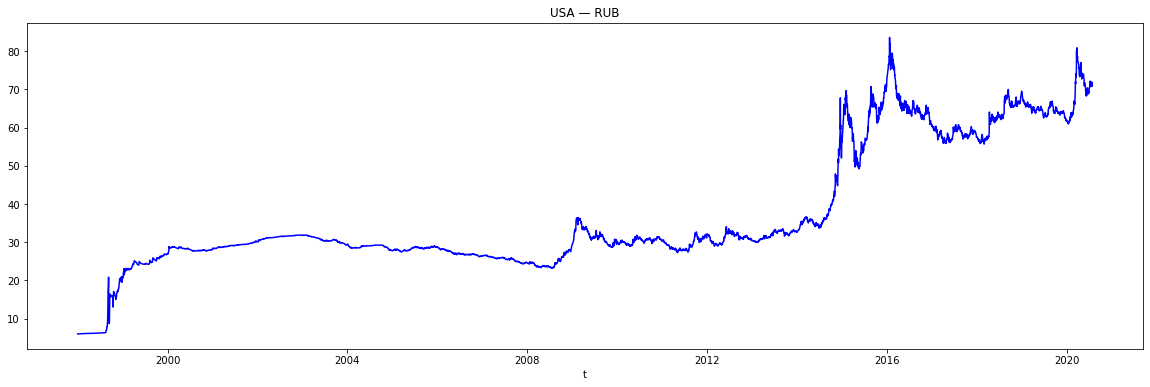

In [16]:
show_plot_data(data_usd, 'value', 'USA — RUB', 't')

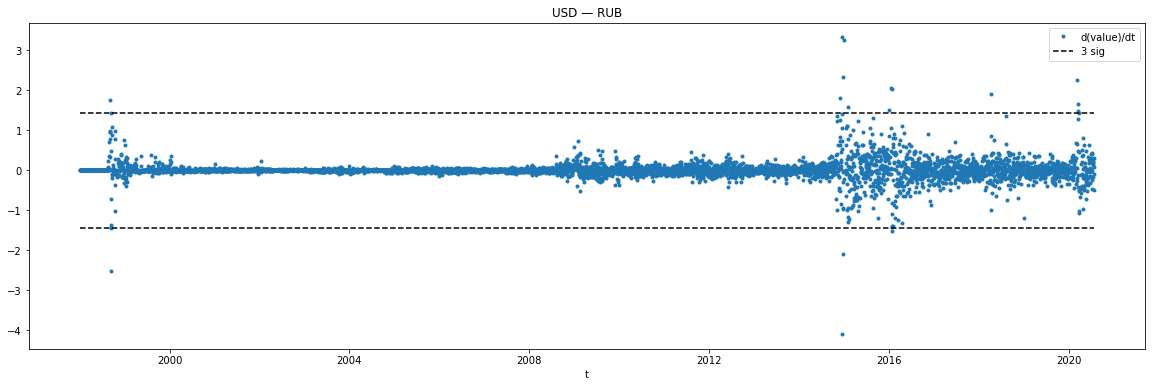

In [17]:
d_data_usd = show_difference(data_usd, 1, 'value', 'd(value)/dt', 'USD — RUB', 't')

In [18]:
data_eur = pd.read_csv('EUR_RUB.csv', index_col=[0], parse_dates=[0])

In [19]:
data_eur.head()

,value
date,
1999-01-07,25.73
1999-01-11,25.89
1999-01-12,26.71
1999-01-13,25.95
1999-01-14,25.24


In [20]:
data_eur.describe()

,value
count,5341.00000
mean,45.14040
std,16.85455
min,23.07000
25%,34.31800
50%,39.45920
75%,60.41240
max,91.18140


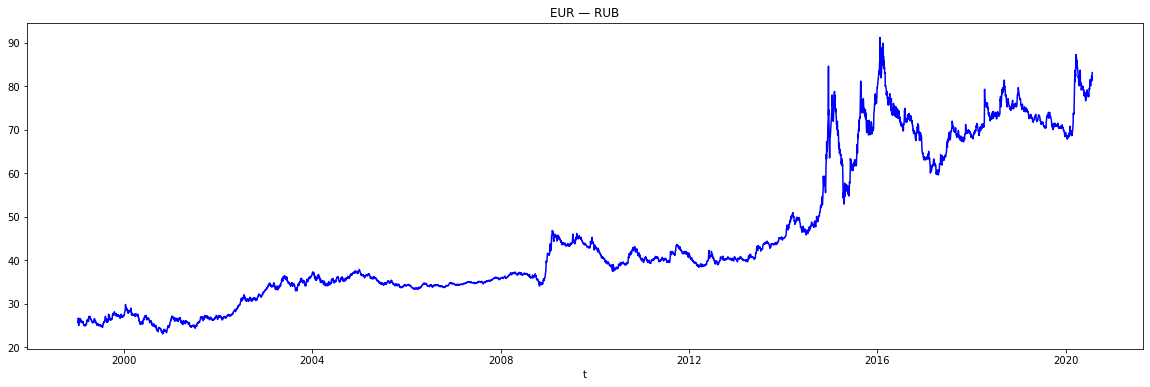

In [21]:
show_plot_data(data_eur, 'value', 'EUR — RUB', 't')

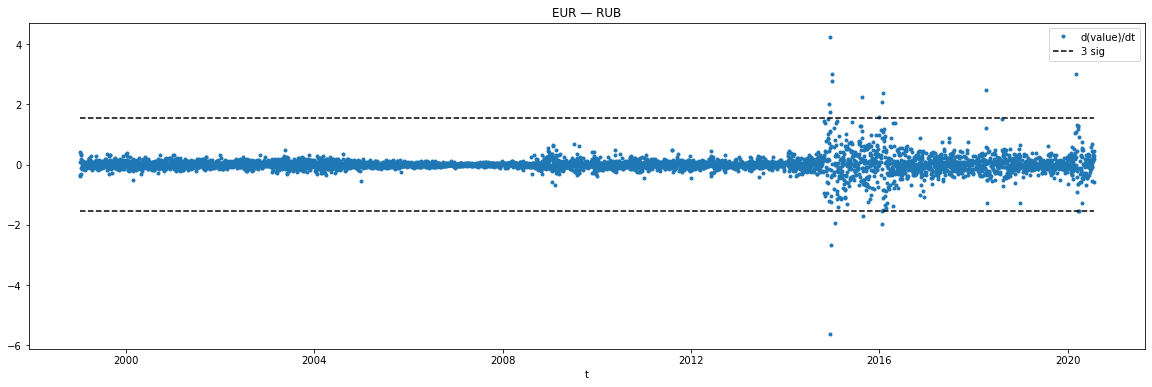

In [22]:
d_data_usd = show_difference(data_eur, 1, 'value', 'd(value)/dt', 'EUR — RUB', 't')

#### Задание 3

Сделайте ее перрасчет (ресемплинг) в представление по неделям.

In [23]:
weekly_summary_usd = pd.DataFrame()
weekly_summary_usd['usd'] = data_usd['value'].resample('W').mean()

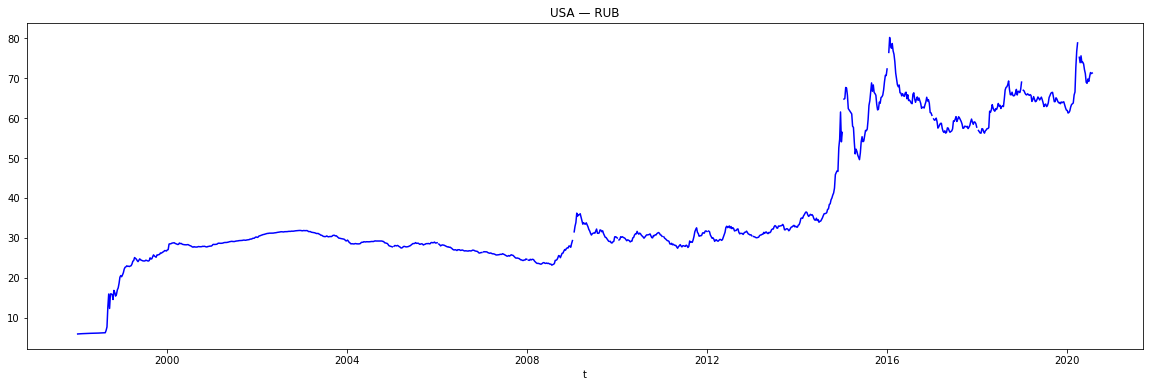

In [24]:
show_plot_data(weekly_summary_usd, 'usd', 'USA — RUB', 't')

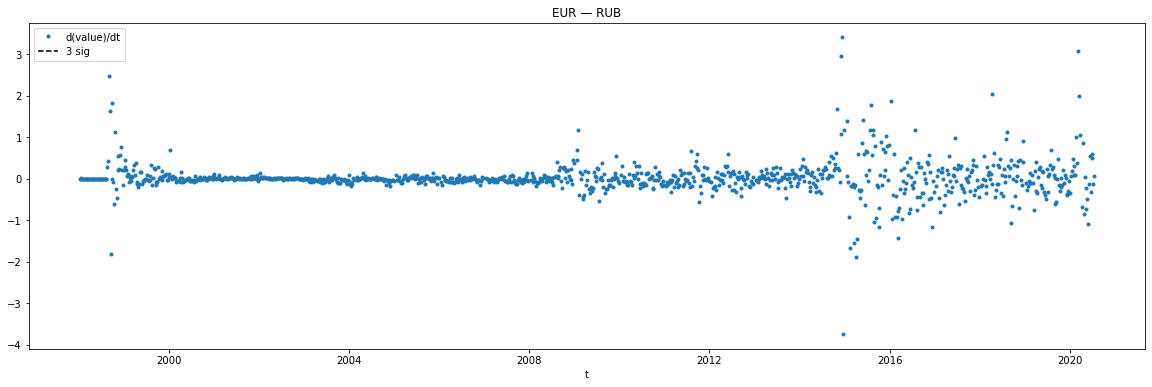

In [25]:
d_weekly_summary_usd = show_difference(weekly_summary_usd, 1, 'usd', 'd(value)/dt', 'EUR — RUB', 't')

In [26]:
weekly_summary_eur = pd.DataFrame()
weekly_summary_eur['eur'] = data_eur['value'].resample('W').mean()

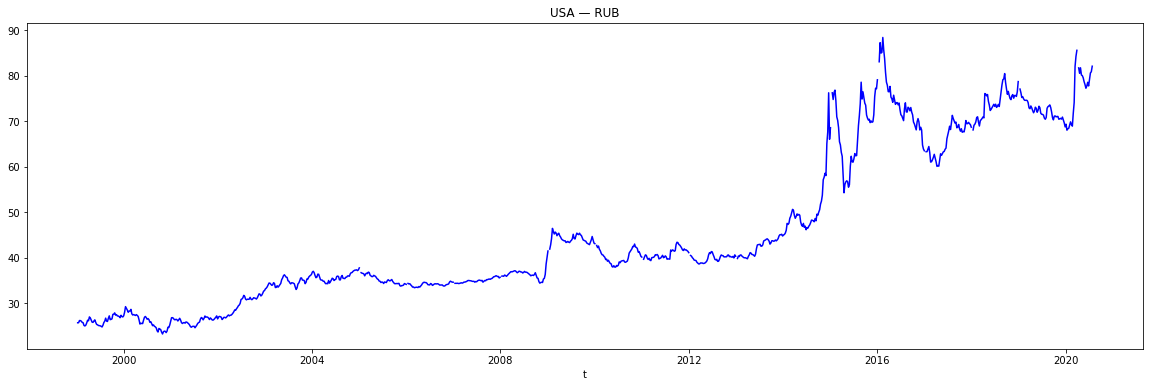

In [27]:
show_plot_data(weekly_summary_eur, 'eur', 'USA — RUB', 't')

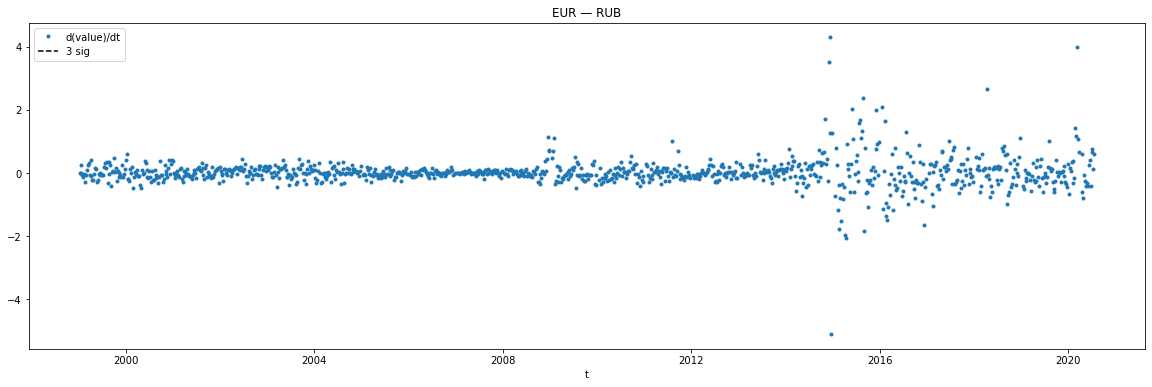

In [28]:
d_weekly_summary_eur = show_difference(weekly_summary_eur, 1, 'eur', 'd(value)/dt', 'EUR — RUB', 't')

#### Задание 4

Постройте модель предсказания 1-й точки от текущей (h=1).

In [29]:
train_usd_b, test_usd_b = split_data_b(data_usd, '01-01-2017', 'date')

X_train_usd_b = train_usd_b.iloc[:-1,:]
y_train_usd_b = train_usd_b[data_usd.columns[0]].values[1:]
X_test_usd_b = test_usd_b.iloc[:-1,:]
y_test_usd_b = test_usd_b[data_usd.columns[0]].values[1:]

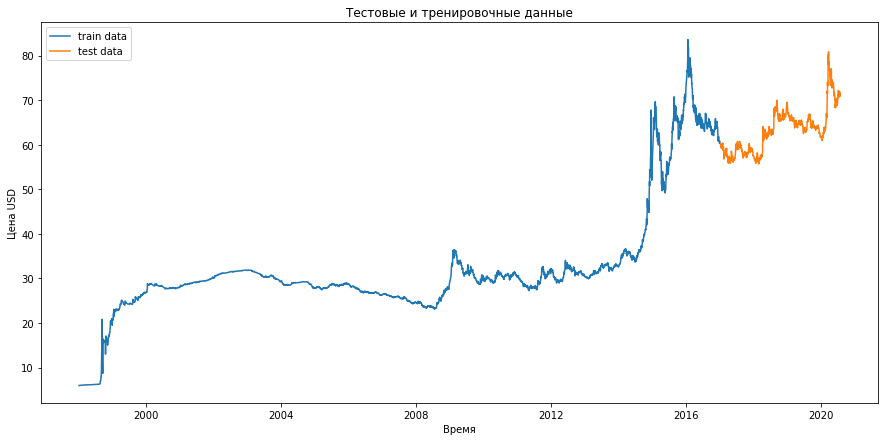

In [30]:
show_train_test_data(train_usd_b,
                     test_usd_b,
                     data_usd,
                     'date',
                     'Время',
                     'Цена USD',
                     'train data',
                     'test data',
                     'Тестовые и тренировочные данные')

In [31]:
h=1
X_train_usd_b = train_usd_b.iloc[:-h,:]
y_train_usd_b = train_usd_b[data_usd.columns[0]].values[h:]
X_test_usd_b = test_usd_b.iloc[:-h,:]
y_test_usd_b = test_usd_b[data_usd.columns[0]].values[h:]

model_gb_usd = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb_usd.fit(X_train_usd_b, y_train_usd_b) 
X_test_usd_pred_gb = model_gb_usd.predict(X_test_usd_b)

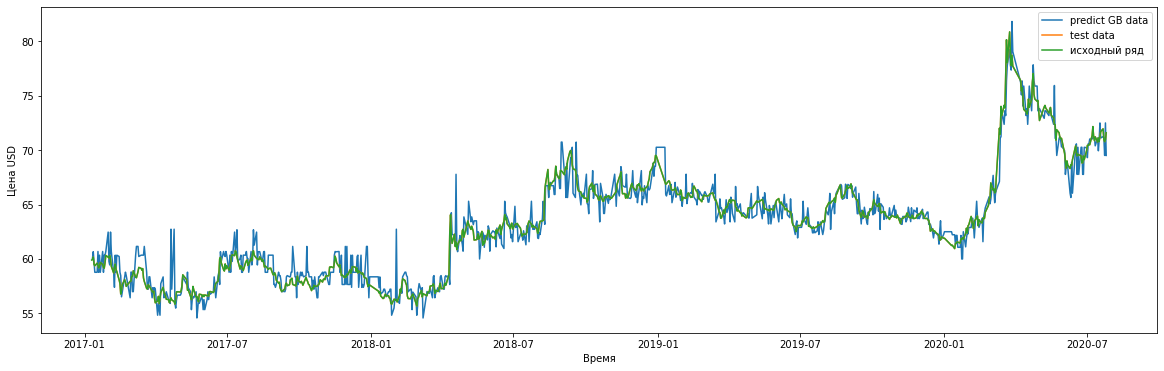

ошибка градиентного бустинга :   1.3141508474524015 %


In [32]:
show_train_test_data_h(test_usd_b,
                       X_test_usd_pred_gb,
                       y_test_usd_b,
                       data_usd,
                       'value',
                       '01-01-2017',
                       'Время',
                       'Цена USD',
                       'predict GB data',
                       'test data',
                       'исходный ряд')

In [33]:
train_eur_b, test_eur_b = split_data_b(data_eur, '01-01-2017', 'date')

X_train_eur_b = train_eur_b.iloc[:-1,:]
y_train_eur_b = train_eur_b[data_eur.columns[0]].values[1:]
X_test_eur_b = test_eur_b.iloc[:-1,:]
y_test_eur_b = test_eur_b[data_eur.columns[0]].values[1:]

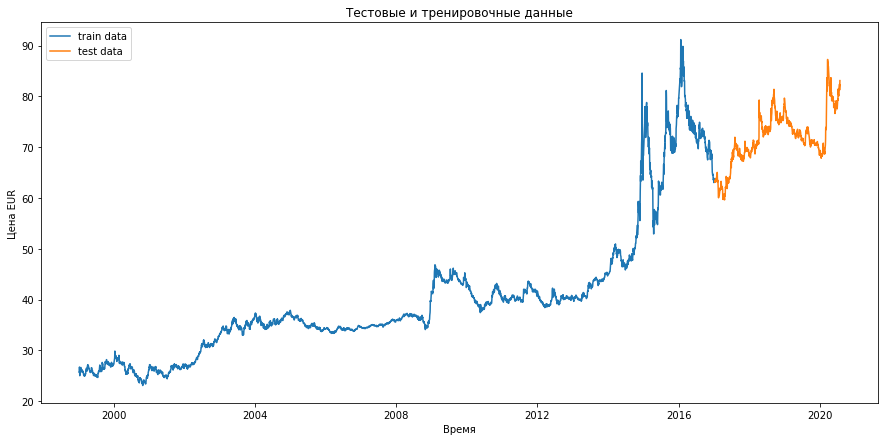

In [34]:
show_train_test_data(train_eur_b,
                     test_eur_b,
                     data_eur,
                     'date',
                     'Время',
                     'Цена EUR',
                     'train data',
                     'test data',
                     'Тестовые и тренировочные данные')

In [35]:
h=1
X_train_eur_b = train_eur_b.iloc[:-h,:]
y_train_eur_b = train_eur_b[data_eur.columns[0]].values[h:]
X_test_eur_b = test_eur_b.iloc[:-h,:]
y_test_eur_b = test_eur_b[data_eur.columns[0]].values[h:]

model_gb_eur = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb_eur.fit(X_train_eur_b, y_train_eur_b) 
X_test_eur_pred_gb = model_gb_eur.predict(X_test_eur_b)

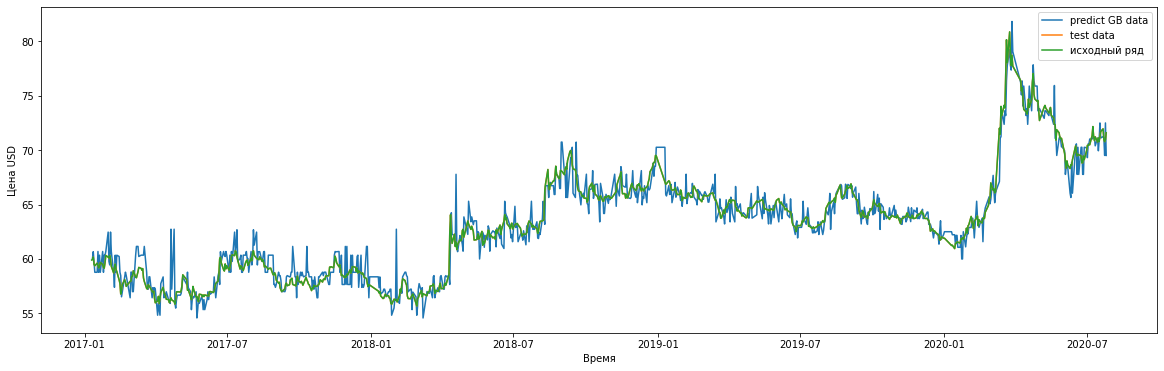

ошибка градиентного бустинга :   1.3141508474524015 %


In [36]:
show_train_test_data_h(test_usd_b,
                       X_test_usd_pred_gb,
                       y_test_usd_b,
                       data_usd,
                       'value',
                       '01-01-2017',
                       'Время',
                       'Цена USD',
                       'predict GB data',
                       'test data',
                       'исходный ряд')

#### Задание 5

Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Ошибка как-то себя ведет.